In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

from efficientnet_pytorch import EfficientNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Custom DataLoader (Assuming you have this defined)
from DataLoader import Data_Loader, ImageDataset

b:\pythonProjects\MelanomaClassification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
b:\pythonProjects\MelanomaClassification\.venv\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# download data set
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cdeotte/jpeg-melanoma-512x512")

print("Path to dataset files:", path)

In [7]:
train_df = pd.read_csv('data/train.csv')  
train_df = train_df.drop(['tfrecord','width','height'],axis=1)
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [3]:
train_df.shape

(33126, 8)

In [3]:
# split the data to fold
from sklearn import model_selection


df = train_df.sample(frac=1).reset_index(drop=True) #shuffles the entire dataset randomly.
df['kfold'] = -1 #adds a new column 'kfold' to the dataframe and initializes all values to -1.
y = train_df.target.values
kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=32) #creates a StratifiedKFold object with 5 splits.

for fold,(x,y) in enumerate(kf.split(X=df,y=y)):
    df.loc[y,'kfold'] = fold
df.to_csv('train_fold_tpu.csv',index=False)

In [2]:
df = pd.read_csv('train_fold_tpu.csv')


In [3]:
from efficientnet_pytorch import EfficientNet 

class EfficientNetClassifier(nn.Module):
    def __init__(self, model_version='b4', num_classes=1, dropout_rate=0.3):
        super(EfficientNetClassifier, self).__init__()
        
        model_name = f'efficientnet-{model_version}'
        # Instance of the EfficientNet model with pre-trained weights
        self.feature_extractor = EfficientNet.from_pretrained(model_name)
        
        # Get the number of input features from the last layer of EfficientNet
        num_features = self.feature_extractor._fc.in_features
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(256, num_classes)
        )
        
    def forward(self, images):
        batch_size = images.shape[0]
        
        # Extract features using the EfficientNet model
        features = self.feature_extractor.extract_features(images)
        
        # Pool and reshape features
        pooled_features = nn.functional.adaptive_avg_pool2d(features, 1).reshape(batch_size, -1)
        
        # Pass pooled features through the classifier
        output = self.classifier(pooled_features)
        
        return output  # Return logits directly

In [4]:
from torchvision.models import mobilenet_v2

class MobileNetV2Classifier(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.3):
        super(MobileNetV2Classifier, self).__init__()
        
        # Load a pre-trained MobileNetV2 model
        self.feature_extractor = mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
        
        # Get the number of input features from the last layer of MobileNetV2
        num_features = self.feature_extractor.last_channel
        
        # Remove the classifier part of the pre-trained model
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-1])
        
        # Define a custom classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, images):
        batch_size = images.size(0)
        
        # Extract features using the MobileNetV2 model
        features = self.feature_extractor(images)
        features = features.mean([2, 3])  # Global Average Pooling
        
        # Pass pooled features through the classifier
        output = self.classifier(features)
        
        return output  # Return logits directly


In [5]:
from torchvision.models import resnet50

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.3):
        super(ResNetClassifier, self).__init__()
        
        # Load a pre-trained ResNet50 model
        self.feature_extractor = resnet50(pretrained=True)
        
        # Get the number of input features for the final layer
        num_features = self.feature_extractor.fc.in_features
        
        # Replace the fully connected layer with an identity layer
        self.feature_extractor.fc = nn.Identity()
        
        # Define a custom classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, images):
        batch_size = images.size(0)
        
        # Extract features using the ResNet model
        features = self.feature_extractor(images)
        
        # Pass extracted features through the classifier
        output = self.classifier(features)
        
        return output  # Return logits directly


In [6]:
modelEffNet = EfficientNetClassifier(model_version='b0', num_classes=1, dropout_rate=0.5)
modelMobileNet = MobileNetV2Classifier()
modelResNet = ResNetClassifier()

class EarlyStopping:
    def __init__(self, patience=7, mode="min", delta=0):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif (self.mode == "min" and score > self.best_score - self.delta) or \
             (self.mode == "max" and score < self.best_score + self.delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        return self.early_stop

# Configuration Parameters
CONFIG = {
    'normalization_mean': (0.485, 0.456, 0.406),
    'normalization_std': (0.229, 0.224, 0.225),
    'image_size': (384, 384),
    'batch_size': 28,
    'num_epochs': 3,
    'learning_rate': 3e-5,
    'weight_decay': 1e-4,
    'early_stopping_patience': 5,
}

# Define Focal Loss function
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Thanh/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


Loaded pretrained weights for efficientnet-b0


100%|██████████| 13.6M/13.6M [00:00<00:00, 100MB/s] 
b:\pythonProjects\MelanomaClassification\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
b:\pythonProjects\MelanomaClassification\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Training epoch function with AMP and debug for batch size
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    total_loss = 0
    predictions = []
    targets = []

    for batch_idx, (data, labels) in enumerate(tqdm(dataloader)):
        # Print batch size for debugging
        # print(f"Training Batch {batch_idx} - Batch size: {data.shape[0]}")
        
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Use AMP for mixed precision training
        with torch.amp.autocast("cuda"):
            outputs = model(data)
            loss = criterion(outputs, labels.unsqueeze(1))
        
        # Backward pass with AMP scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * data.shape[0]
        prob_outputs = torch.sigmoid(outputs).detach().cpu().numpy()
        predictions.extend(prob_outputs.flatten())
        targets.extend(labels.cpu().numpy())
        
    return total_loss / len(dataloader.dataset), predictions, targets

# Validation epoch function with AMP and debug for batch size
def validate_epoch(model, dataloader, criterion, device, scaler):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(tqdm(dataloader)):
            # Print batch size for debugging
            # print(f"Validation Batch {batch_idx} - Batch size: {data.shape[0]}")
            
            data, labels = data.to(device), labels.to(device)
            
            # Use AMP for mixed precision inference
            with torch.amp.autocast('cuda'):
                outputs = model(data)
                loss = criterion(outputs, labels.unsqueeze(1))
            
            total_loss += loss.item() * data.shape[0]
            prob_outputs = torch.sigmoid(outputs).detach().cpu().numpy()
            predictions.extend(prob_outputs.flatten())
            targets.extend(labels.cpu().numpy())
    
    return total_loss / len(dataloader.dataset), predictions, targets

In [8]:
def get_train_transforms():
    return A.Compose([
        A.Normalize(mean=CONFIG['normalization_mean'], std=CONFIG['normalization_std'], max_pixel_value=255.0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.7),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
        A.CLAHE(clip_limit=4.0, p=0.7),
        ToTensorV2(),
    ])

def get_valid_transforms():
    return A.Compose([
        A.Normalize(mean=CONFIG['normalization_mean'], std=CONFIG['normalization_std'], max_pixel_value=255.0),
        ToTensorV2(),
    ])

# Modify your optimizer and scheduler here
def train_model(model, train_fold, df):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load data transformations
    train_transforms = get_train_transforms()
    valid_transforms = get_valid_transforms()
    
    # Prepare training and validation datasets from specified folds
    image_directory = 'data/train'
    train_df = df[df.kfold != train_fold].reset_index(drop=True)
    valid_df = df[df.kfold == train_fold].reset_index(drop=True)

    train_dataset = Data_Loader(image_directory, train_df.image_name.tolist(), train_df.target.values, train_transforms).dataset
    valid_dataset = Data_Loader(image_directory, valid_df.image_name.tolist(), valid_df.target.values, valid_transforms).dataset

    # WeightedRandomSampler for handling class imbalance
    class_sample_counts = train_df['target'].value_counts().sort_index().values
    class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    sample_weights = class_weights[train_df['target'].values]
    weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    # DataLoader with WeightedRandomSampler for training
    train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=4, pin_memory=True, batch_size=CONFIG['batch_size'], sampler=weighted_sampler, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, num_workers=4, pin_memory=True, batch_size=CONFIG['batch_size'], shuffle=False,drop_last=True)
    
    model.to(device)
    loss_criterion = FocalLoss(alpha=0.5, gamma=2.0).to(device)

    # Use AdamW optimizer with weight decay for better generalization
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

    # Scheduler: CosineAnnealingWarmRestarts or ReduceLROnPlateau
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

    # Initialize AMP scaler
    scaler = torch.amp.GradScaler('cuda')

    best_valid_pr_auc = 0.0
    best_model = None
    no_improve_epochs = 0

    for epoch in range(CONFIG['num_epochs']):
        # Training phase
        model.train()
        train_loss, train_predictions, train_targets = train_epoch(model, train_loader, loss_criterion, optimizer, device, scaler)
        
        # Validation phase
        model.eval()
        valid_loss, valid_predictions, valid_targets = validate_epoch(model, valid_loader, loss_criterion, device, scaler)
        
        # Calculate PR AUC scores
        train_pr_auc = average_precision_score(train_targets, train_predictions)
        valid_pr_auc = average_precision_score(valid_targets, valid_predictions)
        train_f1 = f1_score(train_targets, np.round(train_predictions), pos_label=1, zero_division=0)
        valid_f1 = f1_score(valid_targets, np.round(valid_predictions), pos_label=1, zero_division=0)
        print(f"Train F1-Score: {train_f1:.4f}")
        print(f"Valid F1-Score: {valid_f1:.4f}")

        print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: Train Loss: {train_loss:.4f}, Train PR AUC: {train_pr_auc:.4f}, Valid Loss: {valid_loss:.4f}, Valid PR AUC: {valid_pr_auc:.4f}")

        # Update learning rate scheduler
        scheduler.step()  # If using CosineAnnealingWarmRestarts
        # scheduler.step(valid_pr_auc)  # If using ReduceLROnPlateau, use validation PR AUC to trigger adjustments
        
        # Save the best model based on validation PR AUC
        if valid_pr_auc > best_valid_pr_auc:
            best_valid_pr_auc = valid_pr_auc
            best_model = model.state_dict().copy()
            no_improve_epochs = 0
            print("New best model saved based on validation PR AUC")
        else:
            no_improve_epochs += 1
        
        # Early stopping condition
        if no_improve_epochs >= CONFIG['early_stopping_patience']:
            print(f"Early stopping triggered after {epoch+1} epochs with no improvement in PR AUC")
            break

        torch.cuda.empty_cache()
    
    model.load_state_dict(best_model)
    return model, best_model, valid_f1



In [32]:
f1_arr = []
model_type = modelResNet  # Assuming modelMobileNet is defined elsewhere

for i in range(1):
    cur_model, best_model, model_f1 = train_model(model_type, i, df=df)
    f1_arr.append(model_f1)
    
    # Save the model using a valid file name
    torch.save(best_model, f'fold_{i}_ResNet.pth')

average_f1_score = np.mean(f1_arr)
print(f"Average F1 score across different folds: {average_f1_score:.4f}")


100%|██████████| 236/236 [00:27<00:00,  8.44it/s]


Train F1-Score: 0.9949
Valid F1-Score: 1.0000
Epoch 1/3: Train Loss: 0.0025, Train PR AUC: 0.9999, Valid Loss: 0.0001, Valid PR AUC: 1.0000
New best model saved based on validation PR AUC


100%|██████████| 236/236 [00:27<00:00,  8.45it/s]


Train F1-Score: 0.9997
Valid F1-Score: 1.0000
Epoch 2/3: Train Loss: 0.0003, Train PR AUC: 1.0000, Valid Loss: 0.0000, Valid PR AUC: 1.0000


100%|██████████| 236/236 [00:27<00:00,  8.43it/s]

Train F1-Score: 0.9995
Valid F1-Score: 1.0000
Epoch 3/3: Train Loss: 0.0004, Train PR AUC: 1.0000, Valid Loss: 0.0000, Valid PR AUC: 1.0000
Average F1 score across different folds: 1.0000


In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, roc_auc_score, average_precision_score, f1_score

def evaluate_model(model, valid_dataset, device, threshold=0.5):
    model.eval()  
    valid_predictions = []
    valid_targets = []

    with torch.no_grad():
        for valid_data, valid_label in valid_dataset:
            valid_data = valid_data.to(device)
            out = model(valid_data)
            out = torch.sigmoid(out)

            valid_targets.append(valid_label.to(device))  
            valid_predictions.append(out)

    valid_predictions = torch.cat(valid_predictions).cpu()
    valid_targets = torch.cat(valid_targets).cpu()

    # Calculate ROC AUC
    valid_auc_score = roc_auc_score(valid_targets.numpy(), valid_predictions.numpy())
    print(f"AUC: {valid_auc_score:.4f}")

    # Calculate Precision-Recall AUC (PR AUC)
    valid_pr_auc_score = average_precision_score(valid_targets.numpy(), valid_predictions.numpy())
    print(f"PR AUC: {valid_pr_auc_score:.4f}")

    # Calculate metrics for the given threshold
    predicted_classes = (valid_predictions > threshold).int()
    precision = precision_score(valid_targets.numpy(), predicted_classes.numpy(), zero_division=0)
    recall = recall_score(valid_targets.numpy(), predicted_classes.numpy(), zero_division=0)
    f1 = f1_score(valid_targets, predicted_classes, zero_division=0)

    print(f"Threshold: {threshold:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    from sklearn.metrics import precision_recall_curve

    # Calculate Precision-Recall values for different thresholds for plotting
    precisions, recalls, thresholds_pr = precision_recall_curve(valid_targets.numpy(), valid_predictions.numpy())

    # Plot Precision-Recall trade-off curve
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds_pr, precisions[:-1], label="Precision", color='b')
    plt.plot(thresholds_pr, recalls[:-1], label="Recall", color='r')
    plt.axvline(x=threshold, color='g', linestyle='--', label=f'Threshold ({threshold})')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision-Recall Trade-off Curve")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # Display Confusion Matrix at the given threshold
    cm = confusion_matrix(valid_targets.numpy(), predicted_classes.numpy())

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    return cm

AUC: 1.0000
PR AUC: 1.0000
Threshold: 0.5000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


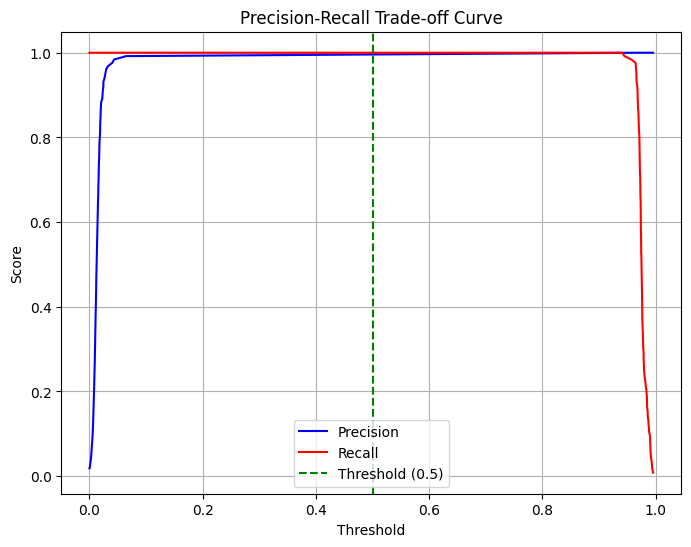

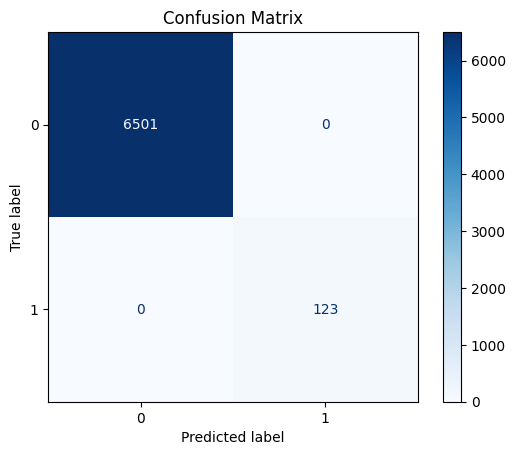

In [18]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

model = modelMobileNet

# Assuming evaluate_model and Data_Loader are defined properly
if __name__ == "__main__":
    fold_number = 0
    
    # Load your trained model
    model_path = 'fold_0_MoibleNet.pth'
    model.load_state_dict(torch.load(model_path,weights_only=True))
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    # Create validation dataset for generating the confusion matrix
    image_path = 'data/train'
    valid_df = df[df.kfold == fold_number].reset_index(drop=True)
    
    valid_im = valid_df.image_name.values.tolist()
    valid_y = valid_df.target.values
    
    

    # Validation transformations
    valid_transpose = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True),
        ToTensorV2()
    ])
    
    # Loading validation dataset
    valid_dataset = Data_Loader(image_path, valid_im, valid_y, valid_transpose).get(batch_size=32, shuffle=False, num_workers=6)

    # Generate and print confusion matrix and metrics
    cm = evaluate_model(model, valid_dataset, device)


This is testing with ISSIC 2019 images to verify the accuracy of the model

Number of overlapping images: 0
False Positives: 26
False Negatives: 0
Visualizing False Positives:


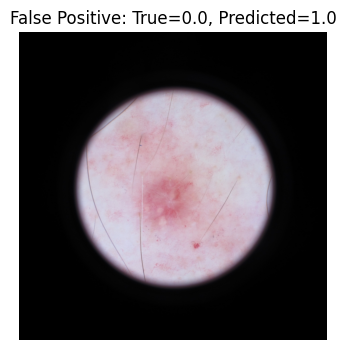

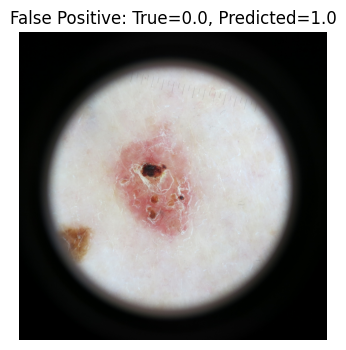

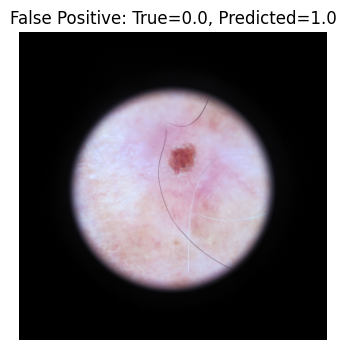

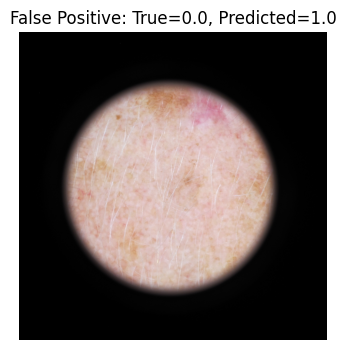

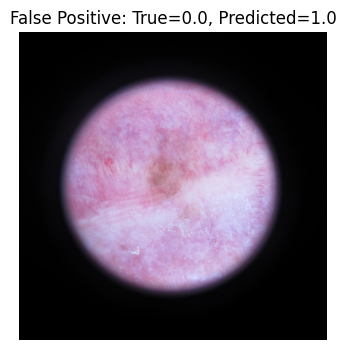

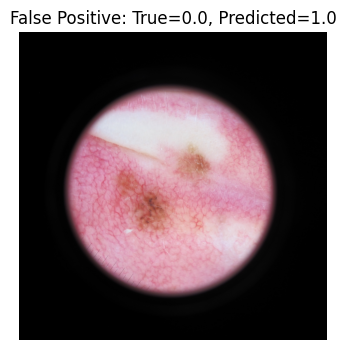

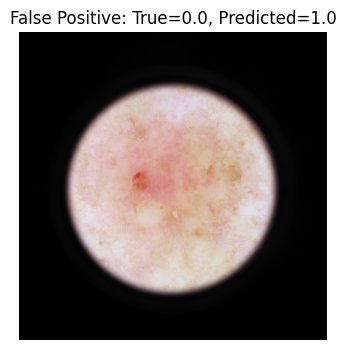

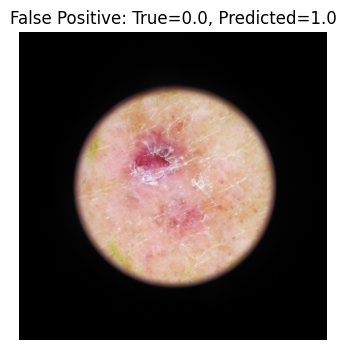

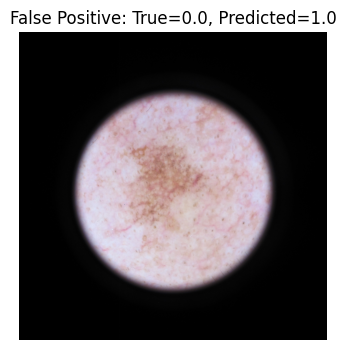

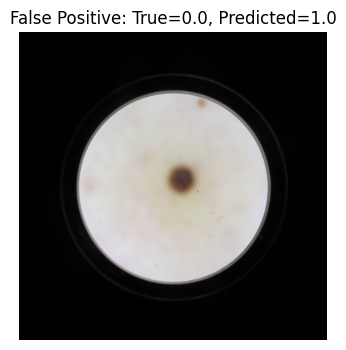

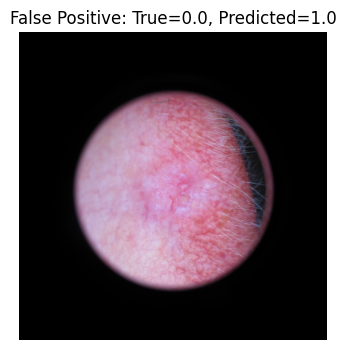

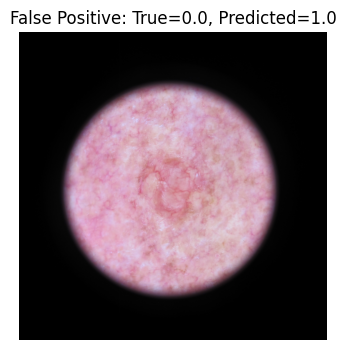

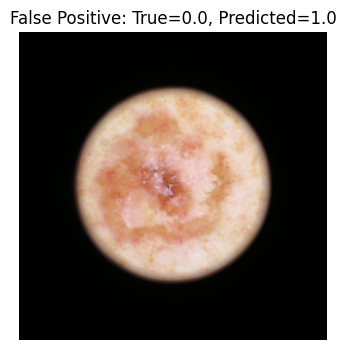

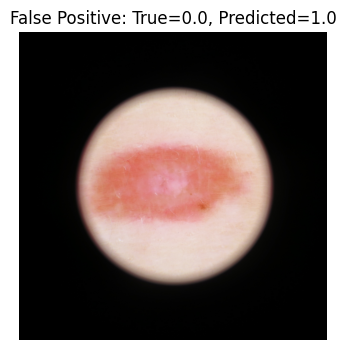

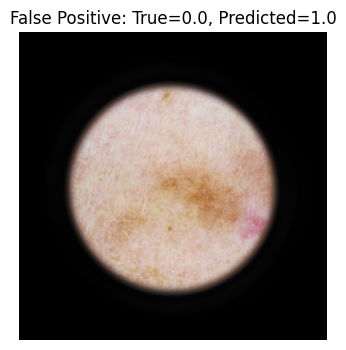

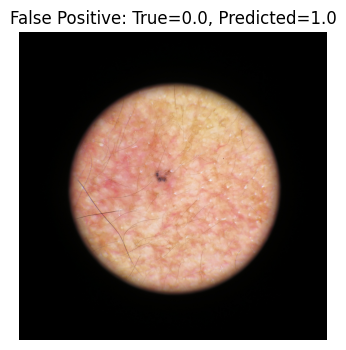

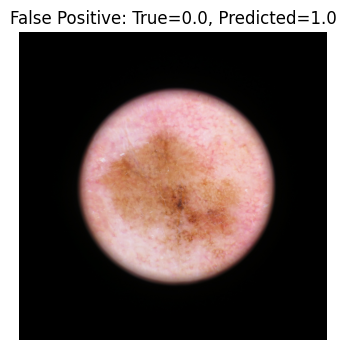

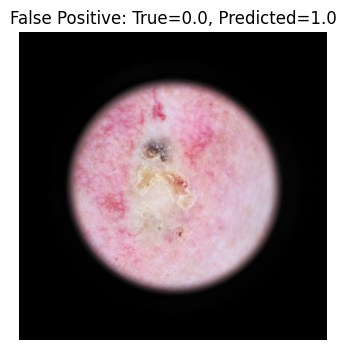

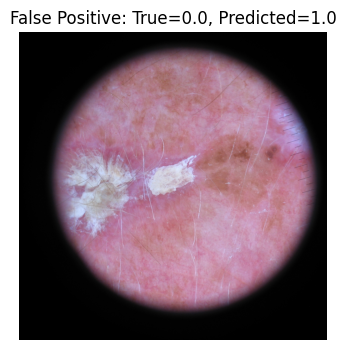

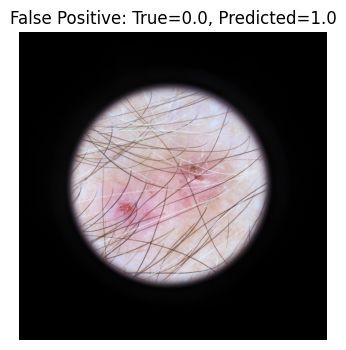

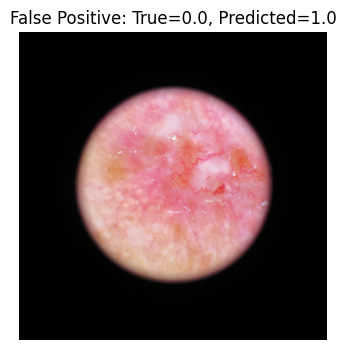

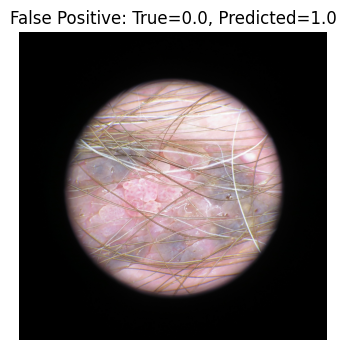

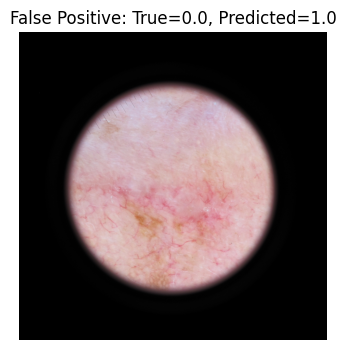

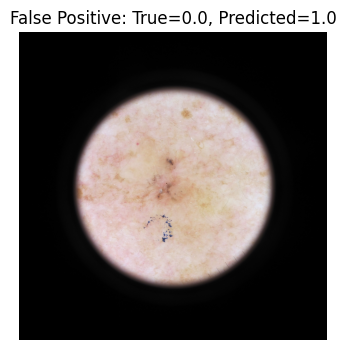

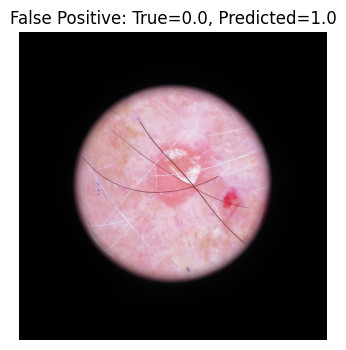

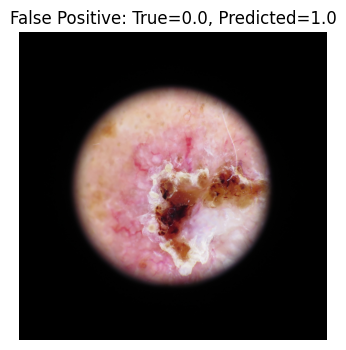

Visualizing False Negatives:
Confusion Matrix:
[[2468   26]
 [   0 2498]]


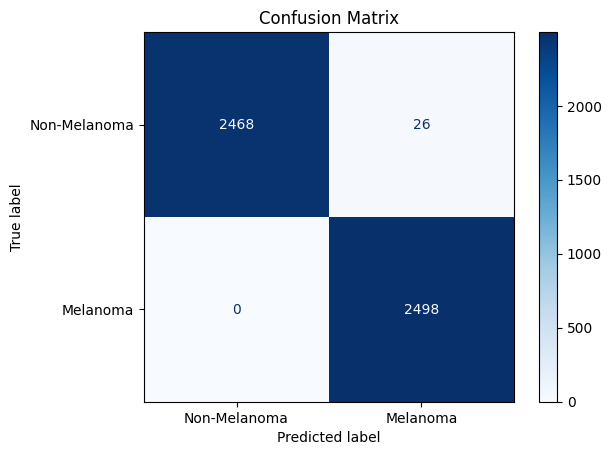

In [19]:
import torch
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import cv2
model = modelMobileNet
# Load model weights
model_path = "fold_0_MoibleNet.pth"
model.load_state_dict(torch.load(model_path,weights_only=True))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Load the train dataset (ISIC 2020) and test dataset (ISIC 2019)
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test_ISIC_2019/ISIC_2019_Training_GroundTruth.csv')

# Rename and drop unnecessary columns in the test dataset
df_test.rename(columns={"MEL": 'target'}, inplace=True)
df_test.drop(columns=['NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], inplace=True)

# Identify and remove overlapping images
common_images = set(df_train['image_name']).intersection(set(df_test['image']))
print(f"Number of overlapping images: {len(common_images)}")
df_test_filtered = df_test[~df_test['image'].isin(common_images)]

# Determine the number of samples to take
total_samples = 5000
positive_samples = 2500  # Number of samples with target = 1
negative_samples = total_samples - positive_samples

# Sample positive and negative cases
df_positive = df_test_filtered[df_test_filtered['target'] == 1].sample(n=positive_samples, random_state=23)
df_negative = df_test_filtered[df_test_filtered['target'] == 0].sample(n=negative_samples, random_state=3)

# Combine the sampled DataFrames
df_sampled = pd.concat([df_positive, df_negative]).sample(frac=1, random_state=42).reset_index(drop=True)

# Prepare image and target lists
test_im = df_sampled.image.values.tolist()
test_target = df_sampled.target.values.tolist()

# Define validation transformations
valid_transpose = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True),
    ToTensorV2()
])

# Loading validation dataset
test_dataset = Data_Loader(
    'data/test_ISIC_2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input', 
    test_im, 
    test_target, 
    valid_transpose
).get(batch_size=32, shuffle=False, num_workers=6)

# Make predictions
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, targets in test_dataset:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs).cpu().numpy()
        all_predictions.extend(predictions)
        all_targets.extend(targets.cpu().numpy())

# Convert predictions to binary
binary_predictions = np.round(all_predictions).flatten()
all_targets = np.array(all_targets)

# Identify incorrect predictions
false_positives = np.where((binary_predictions == 1) & (all_targets == 0))[0]
false_negatives = np.where((binary_predictions == 0) & (all_targets == 1))[0]

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

# Visualize the incorrect predictions
def visualize_incorrect(indices, title):
    for idx in indices:
        img_name = test_im[idx]
        img_path = f'data/test_ISIC_2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/{img_name}.jpg'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"{title}: True={test_target[idx]}, Predicted={binary_predictions[idx]}")
        plt.axis('off')
        plt.show()

# Visualize false positives and false negatives
print("Visualizing False Positives:")
visualize_incorrect(false_positives, "False Positive")

print("Visualizing False Negatives:")
visualize_incorrect(false_negatives, "False Negative")



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(all_targets, binary_predictions)

# Print the confusion matrix values
print("Confusion Matrix:")
print(cm)

# Display the confusion matrix using matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Melanoma", "Melanoma"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



In [2]:
import cv2
from albumentations.pytorch import ToTensorV2

# Define the function to predict melanoma
def predict_melanoma(image_path, model, device):
    """
    Predict whether an image is positive for melanoma.
    
    Args:
    - image_path (str): Path to the image file.
    - model (torch.nn.Module): Pre-trained PyTorch model.
    - device (str): Device to use ('cuda' or 'cpu').

    Returns:
    - prediction (float): Probability of melanoma (0 to 1).
    - result (str): "Positive for Melanoma" or "Negative for Melanoma".
    """
    # Define the transformation
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True),
        ToTensorV2()
    ])
    
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed = transform(image=img)
    img_tensor = transformed["image"].unsqueeze(0).to(device)  # Add batch dimension
    
    # Set model to evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        output = model(img_tensor)
        probability = torch.sigmoid(output).item()
    
    # Determine result
    result = "Positive for Melanoma" if probability >= 0.5 else "Negative for Melanoma"
    
    return probability, result


image_path = "path_to_your_image.jpg"  # Replace with the path to your image
probability, result = predict_melanoma(image_path, model, device)
print(f"Prediction Probability: {probability:.4f}")
print(f"Result: {result}")


NameError: name 'model' is not defined